In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def MA_CROSSOVER(df : pd.DataFrame, lookback_1 : int, lookback_2 : int) :

    dF = df.copy()
 
    dF['SMA'] = dF['Close'].rolling(lookback_1 - 1).mean()
    dF['LMA'] = dF['Close'].rolling(lookback_2 - 1).mean()

    Signal = pd.Series(np.full(len(dF),np.nan), index = dF.index)
    Signal.loc[dF['SMA'] > dF['LMA']] = 1
    Signal.loc[dF['SMA'] < dF['LMA']] = -1
    Signal = Signal.ffill()  

    ##
    counter = 0
    entry = Signal.diff()
    for val in entry : 
        if abs(val) == 2 :
            counter += 1
    ##
    return Signal, counter 

In [3]:
def OPTI_MACO(df : pd.DataFrame) :

    best_profitfactor = 0
    best_lookback_1 = -1
    best_lookback_2 = -1

    returns = np.log(df['Close']).diff().shift(-1).squeeze()

    for lookback1 in range(9,169) :
        for lookback2 in range(9,169) :
            if (lookback1 < lookback2) : 
                
                signal = MA_CROSSOVER(df,lookback1, lookback2)[0]
                SR = (signal * returns).dropna() 
                signal_profitfactor = SR[SR > 0].sum() / SR[SR < 0].abs().sum()
            
                if (signal_profitfactor > best_profitfactor) :
                    best_profitfactor = signal_profitfactor
                    best_lookback_1 = lookback1
                    best_lookback_2 = lookback2

                
                #plt.plot(SR.cumsum(), label = f" {lookback1} : {lookback2} ")
                #plt.legend(loc=2)
                #plt.show()
                

    return best_lookback_1, best_lookback_2, best_profitfactor


In [4]:
def walkforward_MA(ohlc: pd.DataFrame, train_lookback: int = 365 * 4, train_step: int = 30):

    n = len(ohlc)
    wf_signal = np.full(n, np.nan)
    tmp_signal = None
    
    next_train = train_lookback
    for i in range(next_train, n):
        if i == next_train:
            bl1, bl2 , _ = OPTI_MACO(ohlc.iloc[i-train_lookback:i])
            tmp_signal, _ = MA_CROSSOVER(ohlc, bl1, bl2)
            next_train += train_step
        
        wf_signal[i] = tmp_signal.iloc[i]
    
    return wf_signal

/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_12621/1113520400.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_gold = yf.download([symbol], start = '2016-01-31', end = '2020-01-31', interval="1d")
[*********************100%***********************]  1 of 1 completed


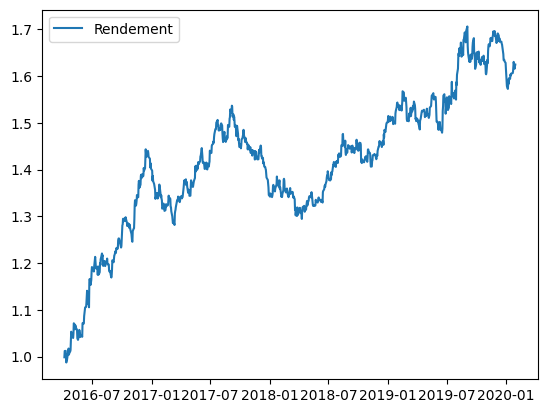

best lookback 1 is : 46
best lookback 2 is : 48
best profit factor is : 1.208403704746325
the number of trades for these lookbacks is 54


In [5]:
symbol = 'GLD'

df_gold = yf.download([symbol], start = '2016-01-31', end = '2020-01-31', interval="1d")

bestLB1, bestLB2, bestPF = OPTI_MACO(df_gold)

SIG1, nb_t_gold = MA_CROSSOVER(df_gold, bestLB1, bestLB2)

df_gold['returns'] = np.log(df_gold['Close']).diff().shift(-1) 
df_gold['system_returns'] = df_gold['returns']*SIG1
plt.plot(np.exp(df_gold['system_returns']).cumprod(), label = 'Rendement')
plt.legend(loc=2)
plt.show()


print(f"best lookback 1 is : {bestLB1}")
print(f"best lookback 2 is : {bestLB2}")
print(f"best profit factor is : {bestPF}")
print(f"the number of trades for these lookbacks is {nb_t_gold}")

/var/folders/6x/40f088zn6lb1tw1zn99534440000gn/T/ipykernel_12621/1127301984.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_btc = yf.download([symbol], start = '2016-01-31', end = '2020-01-31', interval="1d")
[*********************100%***********************]  1 of 1 completed


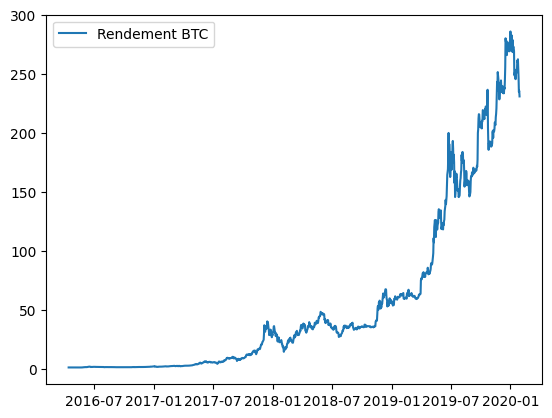

best lookback 1 is : 73
best lookback 2 is : 76
best profit factor is : 1.3485540555573976
the number of trades for these lookbacks is 37


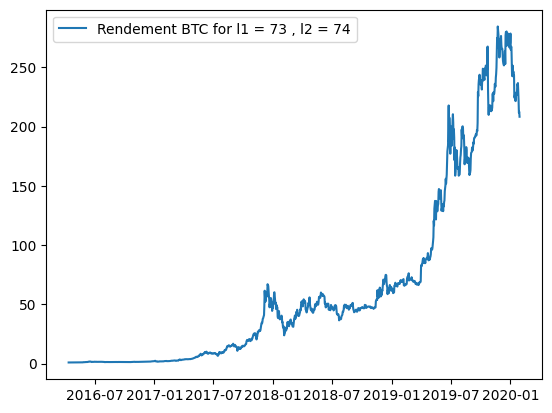

il y a eu 59 trade


In [6]:
symbol = 'BTC-USD'

df_btc = yf.download([symbol], start = '2016-01-31', end = '2020-01-31', interval="1d")
df_copybtc = df_btc.copy()

bestLB1, bestLB2, bestPF = OPTI_MACO(df_btc)

SIG, nb_t_btc = MA_CROSSOVER(df_btc, bestLB1, bestLB2)
SIG2, nb_t_btc_notopty = MA_CROSSOVER(df_copybtc, 73, 74)


df_btc['returns'] = np.log(df_btc['Close']).diff().shift(-1)
df_btc['system_returns'] = df_btc['returns']*SIG
plt.plot(np.exp(df_btc['system_returns']).cumprod(), label = 'Rendement BTC')
plt.legend(loc=2)
plt.show()

print(f"best lookback 1 is : {bestLB1}")
print(f"best lookback 2 is : {bestLB2}")
print(f"best profit factor is : {bestPF}")
print(f"the number of trades for these lookbacks is {nb_t_btc}")


df_copybtc['returns'] = np.log(df_copybtc['Close']).diff().shift(-1)
df_copybtc['system_returns'] = df_copybtc['returns']*SIG2
plt.plot(np.exp(df_copybtc['system_returns']).cumprod(), label = 'Rendement BTC for l1 = 73 , l2 = 74')
plt.legend(loc=2)
plt.show()
print(f"il y a eu {nb_t_btc_notopty} trade")

